In [7]:
%%capture 
!pip install h2o

In [8]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

# 07_1_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/07_1_LEARN_DataAnalysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We can import the data repositoru like this: 

In [9]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 0. Intro
In this study, we aim to use machine learning techniques to predict the best promoter-gene combinations. Machine learning is a powerful tool that allows us to analyze large and complex datasets, identify patterns and make predictions. We will use various machine learning algorithms through the package H2O. 

The machine learning models will be trained on the data from the experiments from[06_1_TEST_LibraryCharacterisation](../colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb), and will learn to predict the best promoter-gene combination based on the observed phenotype and genotype. This will enable us to identify the combination of genes and promoters that result in the highest level of expression or activity, without the need for additional experimentation.

Ultimately, the use of machine learning to predict the best promoter-gene combination will greatly improve the efficiency and allowing us to identify the best combination in a shorter time and with fewer resources.



In this notebook we continue the workflow by using Machine Learning to predict the best promoter:gene combinations of the remaining library that was generated in [05_1_BUILD_CombinatorialLibrary_AllStrain](../colab_notebooks/05_1_BUILD_CombinatorialLibrary_AllStrains.ipynb) and analyzed in [06_1_TEST_LibraryCharacterisation](../colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb). 

## Project overview - Use ML to predicte best promoter:gene combinations 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

Tasks
1. dgRNA
2. Base strain
3. Library
4. Phenotyping
**5. Machine Learning**
   - Predict the best promoter:gene combinations


## 1. Setting up the AutoML library

In [10]:
import h2o
from h2o.automl import H2OAutoML

In [11]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /Users/lucaslevassor/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpnpk9bta0
  JVM stdout: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpnpk9bta0/h2o_lucaslevassor_started_from_python.out
  JVM stderr: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpnpk9bta0/h2o_lucaslevassor_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,16 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_lucaslevassor_c1it1c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.576 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [6]:
#h2o.shutdown()

### 1.1 Import out dataframe to h20 object

Train a model based on the target and the df

In [19]:
# Run ML with new input 
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp49_A01,1,2,5,1,0.271199,0
1,yp49_C01,1,2,5,9,0.149626,0
2,yp49_D01,2,4,7,3,0.049042,0
3,yp49_E01,2,1,5,7,0.096246,0
4,yp49_F01,3,3,6,1,7.365141,25
...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0.000000,0
163,yp51_D12,8,2,7,6,0.202343,0
164,yp51_E12,8,1,6,10,0.153556,0
165,yp50_F05,6,1,8,2,4.656777,13


In [20]:
new_input_for_ml['default_rank'] = new_input_for_ml['Amt_norm'].rank()
new_input_for_ml['max_rank'] = new_input_for_ml['Amt_norm'].rank(method='max')
new_input_for_ml['NA_bottom'] = new_input_for_ml['Amt_norm'].rank(na_option='bottom')
new_input_for_ml['pct_rank'] = new_input_for_ml['Amt_norm'].rank(pct=True)
new_input_for_ml = new_input_for_ml.sort_values(by= 'max_rank', ascending = False)

In [21]:
new_input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm,default_rank,max_rank,NA_bottom,pct_rank
73,yp50_D03,5,2,6,3,85.210149,245,167.0,167.0,167.0,1.000000
75,yp50_G03,6,2,6,5,54.362482,156,166.0,166.0,166.0,0.994012
86,yp50_E05,5,1,6,8,50.194227,144,165.0,165.0,165.0,0.988024
126,yp51_A02,7,2,6,1,46.443319,135,164.0,164.0,164.0,0.982036
106,yp50_A09,4,2,6,3,46.710102,134,163.0,163.0,163.0,0.976048
...,...,...,...,...,...,...,...,...,...,...,...
99,yp50_G07,6,1,5,7,0.000000,0,48.0,95.0,48.0,0.287425
39,yp49_D09,2,3,8,5,0.052854,0,48.0,95.0,48.0,0.287425
40,yp49_E09,2,4,8,9,0.227094,0,48.0,95.0,48.0,0.287425
42,yp49_G09,3,4,6,7,0.091211,0,48.0,95.0,48.0,0.287425


In [22]:
# Choosing which coloums to train on 
new_input_for_ml = new_input_for_ml[['Line_name','0','1','2','3','Amt_norm']]
new_input_for_ml.columns = ['Line_name','0','1','2','3','Amt_norm']

In [23]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:167
Cols:6

,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,int
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.5808383233532926,2.682634730538923,6.562874251497006,5.305389221556887,15.233532934131729
maxs,NaN,8.0,4.0,8.0,10.0,245.0
sigma,NaN,2.253055064641254,1.1621014428030096,1.1696200092422184,2.8363232921290007,36.523955846761694
zeros,0,0,0,0,0,95
missing,0,0,0,0,0,0
0,yp50_D03,5.0,2.0,6.0,3.0,245.0
1,yp50_G03,6.0,2.0,6.0,5.0,156.0
2,yp50_E05,5.0,1.0,6.0,8.0,144.0


In [24]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [25]:
df_test.describe()

Rows:167
Cols:6

,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,int
mins,NaN,,,,,0.0
mean,NaN,,,,,15.233532934131729
maxs,NaN,,,,,245.0
sigma,NaN,,,,,36.523955846761694
zeros,0,,,,,95
missing,0,0,0,0,0,0
0,yp50_D03,5,2,6,3,245.0
1,yp50_G03,6,2,6,5,156.0
2,yp50_E05,5,1,6,8,144.0


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## NOTE: IF you don't want to run the autoML skip the next few paragraphs and go to 4

## 2. RUN automl

Here we are defining the autoML object and after we can train it

In [26]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=0,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=10,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
#    exclude_algos = ["StackedEnsemble"],
    sort_metric = "MAE",
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 


It has been Commented out and saved as showed below

In [27]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 ) 

AutoML progress: |█
10:46:48.697: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 167.0.

██████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 50.8 s, sys: 4.41 s, total: 55.2 s
Wall time: 59min 35s


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230201_104644_model_58


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight           weight_rms          mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  --------------------  ------------------  --------------------  -----------------------
    1        30       Input             0.0
    2        50       RectifierDropout  50.0       0.0   0.0   0.14153930723818484    0.3476378917694092    0.0         -0.07521158719650703  0.4997161626815796  -0.26781051759262686  0.2556114196777344
    3        1        Linear                       0.0   0.0   0.0009726229096122551  0.003230801783502102  0.0         -0.08209915764629841  0.4046359062194824  -0.39262398789470215  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 37.068706952172235
RMSE: 6.088407587552942
MAE: 2.728627138605333
RMSLE: 0.5554433994240296
Mean Residual Deviance: 37.068706952172235

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 327.7617727264971
RMSE: 18.104192131285426
MAE: 8.037346736078618
RMSLE: NaN
Mean Residual Deviance: 327.7617727264971

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     8.03034   3.95942    14.4279       6.64181       6.37023       5.20376       4.35421       6.90536       13.4793       12.8442       6.02368       4.05291
mean_residual_deviance  328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
mse                     328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
r2                      0.729258  0.310538   0.754488      0.891373      0.905812      0.949212      0.954273      0.819721      0.193679      0.111321      0.827843      0.884858
residual_deviance       328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
rmse                    15.838    9.26393    29.2596       13.0852       11.3687       7.91969       7.39156       14.1093       27.7573       29.4625       10.8567       7.169
rmsle                   0.955662  0.0725219  nan           1.00694       0.904381      nan           nan           nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2023-02-01 11:18:11  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2023-02-01 11:18:11  18 min 22.700 sec  334000 obs/sec    10        1             1670         33.8833          1148.08              17.0072         0.134185
    2023-02-01 11:18:13  18 min 24.458 sec  951434 obs/sec    10010     1001          1.67167e+06  

In [28]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [29]:
## Saving the leaderboard ids
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])


### 3.1 Saving the best model

In [30]:
# how to save any model
out_path = 'ConStrain_on_google_colab/data/09-AutoML/best_models/first_round/'
mdl = h2o.get_model(model_ids[0])
h2o.save_model(model=mdl, path=out_path, force=True)

'/Users/lucaslevassor/projects/ConStrain/colab_notebooks/ConStrain_on_google_colab/data/09-AutoML/best_models/first_round/DeepLearning_grid_1_AutoML_1_20230201_104644_model_58'

### 3.2 Saving the leaderboard

In [31]:
# saving the leaderboard
out_path = 'ConStrain_on_google_colab/data/09-AutoML/leaderboards/first_round/'
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [32]:
# saving the models
#leaderboard = AutoML.leaderboard
#lb= leaderboard
#model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])
#
#out_path = 'ConStrain_on_google_colab/data/09-AutoML/leaderboards/first_round/'
#for m_id in model_ids:
#     mdl = h2o.get_model(m_id)
#     h2o.save_model(model=mdl, path=out_path, force=True)

In [33]:
len(model_ids)

1895

Now we want to extract the best models

In [34]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,mae,rmse,mse,rmsle,mean_residual_deviance
0,DeepLearning_grid_1_AutoML_1_20230201_104644_m...,8.037347,18.104192,327.761773,NaN,327.761773
1,DeepLearning_grid_1_AutoML_1_20230201_104644_m...,8.042375,17.724106,314.143921,NaN,314.143921
2,DeepLearning_grid_1_AutoML_1_20230201_104644_m...,8.152435,17.615892,310.319651,NaN,310.319651
3,StackedEnsemble_BestOfFamily_6_AutoML_1_202302...,8.286653,18.255967,333.280330,NaN,333.280330
4,StackedEnsemble_Best1000_1_AutoML_1_20230201_1...,8.325098,18.227486,332.241250,NaN,332.241250
...,...,...,...,...,...,...
1890,DeepLearning_grid_2_AutoML_1_20230201_104644_m...,51.161474,73.062261,5338.093986,NaN,5338.093986
1891,DeepLearning_grid_2_AutoML_1_20230201_104644_m...,61.962407,77.870729,6063.850451,NaN,6063.850451
1892,DeepLearning_grid_3_AutoML_1_20230201_104644_m...,65.395572,79.392010,6303.091299,NaN,6303.091299
1893,DeepLearning_grid_2_AutoML_1_20230201_104644_m...,69.948891,85.997024,7395.488137,NaN,7395.488137


In [35]:
best_model = AutoML.get_best_model()
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230201_104644_model_58


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight           weight_rms          mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  --------------------  ------------------  --------------------  -----------------------
    1        30       Input             0.0
    2        50       RectifierDropout  50.0       0.0   0.0   0.14153930723818484    0.3476378917694092    0.0         -0.07521158719650703  0.4997161626815796  -0.26781051759262686  0.2556114196777344
    3        1        Linear                       0.0   0.0   0.0009726229096122551  0.003230801783502102  0.0         -0.08209915764629841  0.4046359062194824  -0.39262398789470215  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 37.068706952172235
RMSE: 6.088407587552942
MAE: 2.728627138605333
RMSLE: 0.5554433994240296
Mean Residual Deviance: 37.068706952172235

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 327.7617727264971
RMSE: 18.104192131285426
MAE: 8.037346736078618
RMSLE: NaN
Mean Residual Deviance: 327.7617727264971

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     8.03034   3.95942    14.4279       6.64181       6.37023       5.20376       4.35421       6.90536       13.4793       12.8442       6.02368       4.05291
mean_residual_deviance  328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
mse                     328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
r2                      0.729258  0.310538   0.754488      0.891373      0.905812      0.949212      0.954273      0.819721      0.193679      0.111321      0.827843      0.884858
residual_deviance       328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
rmse                    15.838    9.26393    29.2596       13.0852       11.3687       7.91969       7.39156       14.1093       27.7573       29.4625       10.8567       7.169
rmsle                   0.955662  0.0725219  nan           1.00694       0.904381      nan           nan           nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2023-02-01 11:18:11  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2023-02-01 11:18:11  18 min 22.700 sec  334000 obs/sec    10        1             1670         33.8833          1148.08              17.0072         0.134185
    2023-02-01 11:18:13  18 min 24.458 sec  951434 obs/sec    10010     1001          1.67167e+06  

### 3.4 saving the CV-holdout predictions 


In [106]:
# Get the predictions
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()

# make the df_test to a dataframe
as_data_frame_df_test = df_test.as_data_frame()

# Make cv_pred to a dataframe
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()
as_data_frame_CV_predictions.columns = ['cv_holdout_predictions']
as_data_frame_CV_predictions

,cv_holdout_predictions
0,182.026346
1,126.638507
2,108.859392
3,116.967918
4,112.586929
...,...
162,11.365411
163,-0.038407
164,0.125397
165,1.437249


In [171]:
# merge with the test dataframe
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3['ranked_pct'] = df3['Amt_norm'].rank(pct= True)
df3['cv_holdout_predictions_ranked_pct'] = df3['cv_holdout_predictions'].rank(pct= True)
df3

,index,Line_name,0,1,2,3,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct
0,0,yp50_D03,5,2,6,3,245,182.026346,1.000000,0.994012
1,1,yp50_G03,6,2,6,5,156,126.638507,0.994012,0.982036
2,2,yp50_E05,5,1,6,8,144,108.859392,0.988024,0.958084
3,3,yp51_A02,7,2,6,1,135,116.967918,0.982036,0.970060
4,4,yp50_A09,4,2,6,3,134,112.586929,0.976048,0.964072
...,...,...,...,...,...,...,...,...,...,...
162,100,yp51_C12,8,3,7,2,0,0.465466,0.287425,0.326347
163,99,yp51_D12,8,2,7,6,0,-4.656575,0.287425,0.029940
164,98,yp51_E12,8,1,6,10,0,-20.376793,0.287425,0.005988
165,97,yp49_D01,2,4,7,3,0,0.592112,0.287425,0.374251


In [172]:
df3  = df3[['Line_name', '0', '1', '2', '3', 'Amt_norm','cv_holdout_predictions', 'ranked_pct','cv_holdout_predictions_ranked_pct']]

In [173]:
# save it to the folder
df3.to_csv('ConStrain_on_google_colab/data/09-AutoML/cv_holdout_predictions/first_round/cv_holdout_predictions.csv', index=False)

## 4. Importing the best model

### 4.1 Importing the leaderboard

In [167]:
models_path = "ConStrain_on_google_colab/data/09-AutoML/leaderboards/first_round/"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DeepLearning_grid_1_AutoML_1_20230201_104644_model_58,8.03735,18.1042,327.762,nan,327.762
DeepLearning_grid_1_AutoML_1_20230201_104644_model_92,8.04238,17.7241,314.144,nan,314.144
DeepLearning_grid_1_AutoML_1_20230201_104644_model_13,8.15243,17.6159,310.32,nan,310.32
StackedEnsemble_BestOfFamily_6_AutoML_1_20230201_104644,8.28665,18.256,333.28,nan,333.28
StackedEnsemble_Best1000_1_AutoML_1_20230201_104644,8.3251,18.2275,332.241,nan,332.241
StackedEnsemble_BestOfFamily_5_AutoML_1_20230201_104644,8.33928,20.2976,411.993,nan,411.993
StackedEnsemble_BestOfFamily_4_AutoML_1_20230201_104644,8.36795,17.9179,321.05,nan,321.05
DeepLearning_grid_1_AutoML_1_20230201_104644_model_68,8.41505,17.406,302.968,nan,302.968
DeepLearning_grid_1_AutoML_1_20230201_104644_model_49,8.4392,17.4249,303.628,nan,303.628
DeepLearning_grid_1_AutoML_1_20230201_104644_model_44,8.49537,19.5019,380.325,nan,380.325


In [168]:
best_model = h2o.load_model("ConStrain_on_google_colab/data/09-AutoML/best_models/first_round/"+lb[0,0]) 
#ConStrain/colab_notebooks/ConStrain_on_google_colab/data/09-AutoML/best_models/first_round/XGBoost_grid_1_AutoML_1_20230127_102805_model_165
#my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/data/09-AutoML/best_models/first_round/")
#uploaded_model = h2o.upload_model(my_local_model)

In [169]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230201_104644_model_58


Status of Neuron Layers: predicting Amt_norm, regression, gaussian distribution, Quadratic loss, 1,601 weights/biases, 22.4 KB, 1,671,670 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight           weight_rms          mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  --------------------  ------------------  --------------------  -----------------------
    1        30       Input             0.0
    2        50       RectifierDropout  50.0       0.0   0.0   0.14153930723818484    0.3476378917694092    0.0         -0.07521158719650703  0.4997161626815796  -0.26781051759262686  0.2556114196777344
    3        1        Linear                       0.0   0.0   0.0009726229096122551  0.003230801783502102  0.0         -0.08209915764629841  0.4046359062194824  -0.39262398789470215  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 37.068706952172235
RMSE: 6.088407587552942
MAE: 2.728627138605333
RMSLE: 0.5554433994240296
Mean Residual Deviance: 37.068706952172235

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 327.7617727264971
RMSE: 18.104192131285426
MAE: 8.037346736078618
RMSLE: NaN
Mean Residual Deviance: 327.7617727264971

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     8.03034   3.95942    14.4279       6.64181       6.37023       5.20376       4.35421       6.90536       13.4793       12.8442       6.02368       4.05291
mean_residual_deviance  328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
mse                     328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
r2                      0.729258  0.310538   0.754488      0.891373      0.905812      0.949212      0.954273      0.819721      0.193679      0.111321      0.827843      0.884858
residual_deviance       328.08    351.632    856.122       171.223       129.248       62.7214       54.6352       199.073       770.469       868.041       117.868       51.3946
rmse                    15.838    9.26393    29.2596       13.0852       11.3687       7.91969       7.39156       14.1093       27.7573       29.4625       10.8567       7.169
rmsle                   0.955662  0.0725219  nan           1.00694       0.904381      nan           nan           nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2023-02-01 11:18:11  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2023-02-01 11:18:11  18 min 22.700 sec  334000 obs/sec    10        1             1670         33.8833          1148.08              17.0072         0.134185
    2023-02-01 11:18:13  18 min 24.458 sec  951434 obs/sec    10010     1001          1.67167e+06  

### 4.1 Investigate the best model - Cross-validation holdout predictions

Get the cross validation predictions

In [182]:
df3 = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/cv_holdout_predictions/first_round/cv_holdout_predictions.csv')
df3

,Line_name,0,1,2,3,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct
0,yp50_D03,5,2,6,3,245,182.026346,1.000000,0.994012
1,yp50_G03,6,2,6,5,156,126.638507,0.994012,0.982036
2,yp50_E05,5,1,6,8,144,108.859392,0.988024,0.958084
3,yp51_A02,7,2,6,1,135,116.967918,0.982036,0.970060
4,yp50_A09,4,2,6,3,134,112.586929,0.976048,0.964072
...,...,...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0,0.465466,0.287425,0.326347
163,yp51_D12,8,2,7,6,0,-4.656575,0.287425,0.029940
164,yp51_E12,8,1,6,10,0,-20.376793,0.287425,0.005988
165,yp49_D01,2,4,7,3,0,0.592112,0.287425,0.374251


In [183]:
#cross_validation_holdout_predictions = best_model.predict(df_test)

In [184]:
# This is where list of cv preds are stored (one element per fold):
#cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()

In [185]:
#cross_validation_holdout_predictions.frame_id

In [186]:
#cv_fram = cross_validation_holdout_predictions.as_data_frame()
#cv_fram

In [187]:
# However you most likely want a single-column frame including all cv preds
#cross_validation_predictions = best_model.cross_validation_predictions()
#print(len(cross_validation_predictions))

In [188]:
#as_data_frame_df_test = df_test.as_data_frame()
#as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [189]:
#df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True).sort_values(by= 'Amt_norm', ascending = False).reset_index()
#df3.head(10)

#### Barplot of production vs prediction 

In [190]:
from constrain.plotting.plotting import bar_plot_w_hue

In [191]:
%%capture
# initialize
ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']
ds2 = df3[['Line_name', 'cv_holdout_predictions']]
ds2.columns = ['Line_name', 'strict']

# add category
ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

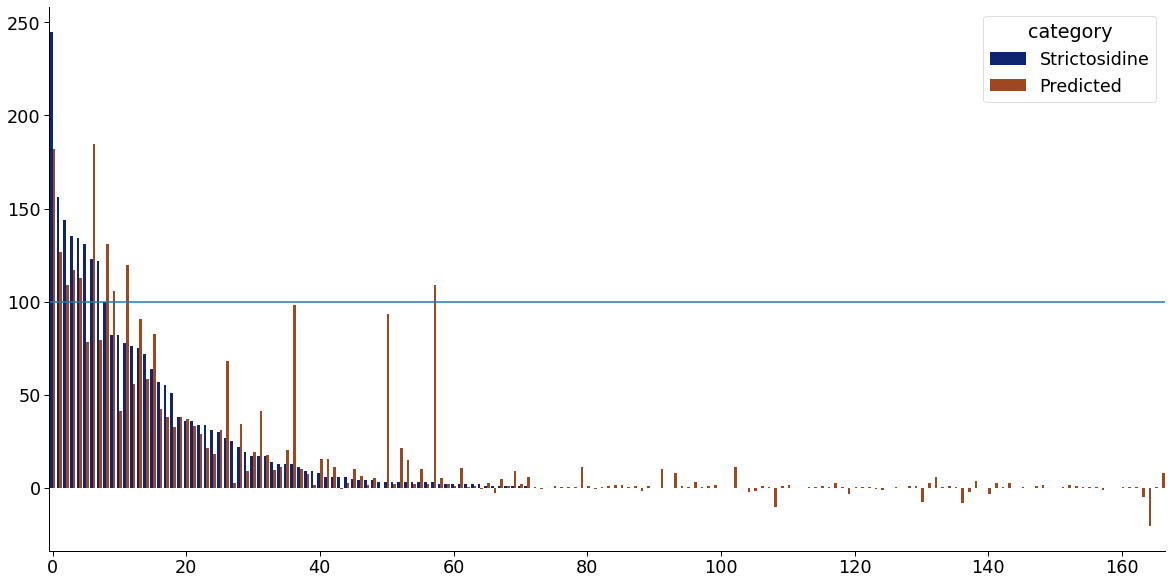

In [194]:
bar_plot_w_hue(dss, 'Line_name', 'strict', 
               path = 'ConStrain_on_google_colab/data/10-plots/07_1_LEARN_DataAnalysis/Prediction of the sampled library_ranked',
               palette = 'dark',
              size_height= 10, 
              size_length = 20)

#### Ranking production and correlation plots 

In [195]:
df3['norm_strict_measured_rank_pct']= df3['Amt_norm'].rank(pct=True)
df3['cv_holdout_predictions_rank_pct'] = df3['cv_holdout_predictions'].rank(pct=True)
df3.to_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/input_for_ml_1st_iteration_w_predictions_and_ranking_2701.csv',index=False)
df3

,Line_name,0,1,2,3,Amt_norm,cv_holdout_predictions,ranked_pct,cv_holdout_predictions_ranked_pct,norm_strict_measured_rank_pct,cv_holdout_predictions_rank_pct
0,yp50_D03,5,2,6,3,245,182.026346,1.000000,0.994012,1.000000,0.994012
1,yp50_G03,6,2,6,5,156,126.638507,0.994012,0.982036,0.994012,0.982036
2,yp50_E05,5,1,6,8,144,108.859392,0.988024,0.958084,0.988024,0.958084
3,yp51_A02,7,2,6,1,135,116.967918,0.982036,0.970060,0.982036,0.970060
4,yp50_A09,4,2,6,3,134,112.586929,0.976048,0.964072,0.976048,0.964072
...,...,...,...,...,...,...,...,...,...,...,...
162,yp51_C12,8,3,7,2,0,0.465466,0.287425,0.326347,0.287425,0.326347
163,yp51_D12,8,2,7,6,0,-4.656575,0.287425,0.029940,0.287425,0.029940
164,yp51_E12,8,1,6,10,0,-20.376793,0.287425,0.005988,0.287425,0.005988
165,yp49_D01,2,4,7,3,0,0.592112,0.287425,0.374251,0.287425,0.374251


In [196]:
from constrain.plotting.plotting import correlation_plot

In [197]:
#correlation_plot(df3,"Amt_norm","cv_holdout_predictions", save_pdf = True , 
#                 path ='ConStrain_on_google_colab/data/10-plots/07_1_LEARN_DataAnalysis/corr_plot_Amt_predict')

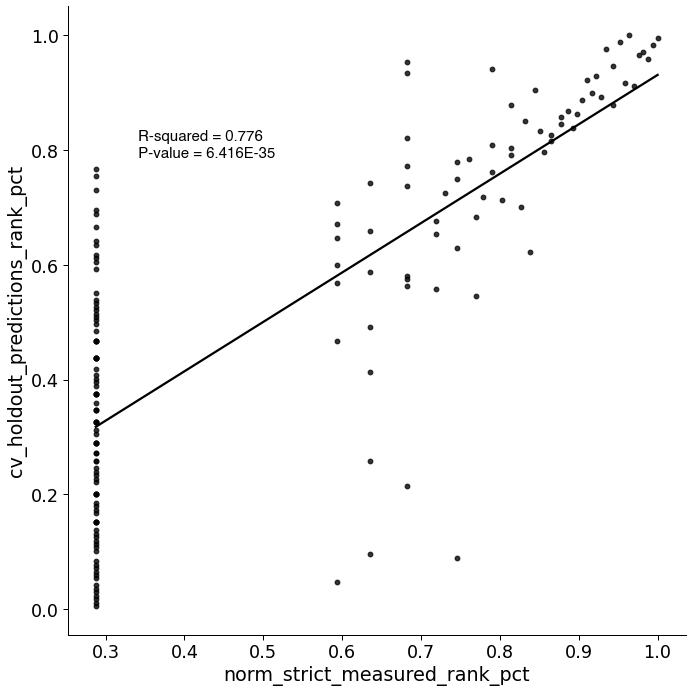

In [198]:
correlation_plot(df3,"norm_strict_measured_rank_pct","cv_holdout_predictions_rank_pct", save_pdf = True , 
                 path ='ConStrain_on_google_colab/data/10-plots/07_1_LEARN_DataAnalysis/corr_plot_rank_rank_predict')

## 5. Clean up data on the remaining library of combinations of genotypes

In [199]:
import numpy as np

In [200]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/data/03-strain_sequences/systematic_names_of_all_strains/systematic_names_on_all_combinations.csv')
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,3
1,1,5,4
1,1,5,5
1,1,5,6
1,1,5,7
1,1,5,8
1,1,5,9
1,1,5,10


In [201]:
input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
73,5,2,6,3
75,6,2,6,5
86,5,1,6,8
126,7,2,6,1
106,4,2,6,3
...,...,...,...,...
99,6,1,5,7
39,2,3,8,5
40,2,4,8,9
42,3,4,6,7


Getting rid of the genotypes we have already tested:

In [202]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
3,1,1,5,4
4,1,1,5,5
6,1,1,5,7
...,...,...,...,...
1275,8,4,8,6
1276,8,4,8,7
1277,8,4,8,8
1278,8,4,8,9


In [203]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## 6. Predict the  phenotypes from the whole library

In [204]:
predicted = best_model.predict(all_genotypes_df)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [205]:
len(predicted)

1121

In [206]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,0.627268
1,0.893352
2,0.882574
3,0.019437
4,0.750782


In [207]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1020/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
690,5,2,6,1,189.410583
697,5,2,6,8,184.930663
691,5,2,6,2,183.786563
852,6,2,6,3,179.451003
682,5,2,5,3,177.130989
...,...,...,...,...,...
176,2,1,6,7,-19.791379
13,1,1,6,4,-22.477388
975,7,1,6,6,-27.497594
976,7,1,6,7,-32.604113


If we want the names on the genotypes we can do the following: 

In [208]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

In [209]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(10)

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,189.410583
1,Smus,ENO2,TPI1,Cac,184.930663
2,Smus,ENO2,TPI1,Aan,183.786563
3,Rsep,ENO2,TPI1,Ara,179.451003
4,Smus,ENO2,CCW12,Ara,177.130989
5,Rsep,ENO2,TPI1,Cro,170.566436
6,Smus,ENO2,TPI1,Rse,164.283399
7,Rsep,ENO2,TPI1,Cac,164.036205
8,Rsep,ENO2,CCW12,Ara,159.52189
9,Rsep,ENO2,TPI1,Aan,158.31551


In [210]:
from constrain.plotting.plotting import bar_plot
bar_plot

<function constrain.plotting.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None, size_height: int = 25, size_length: int = 15) -> None>

#### 6.1 Plot of predicted strictosidine production across all promoter:homolog combinations

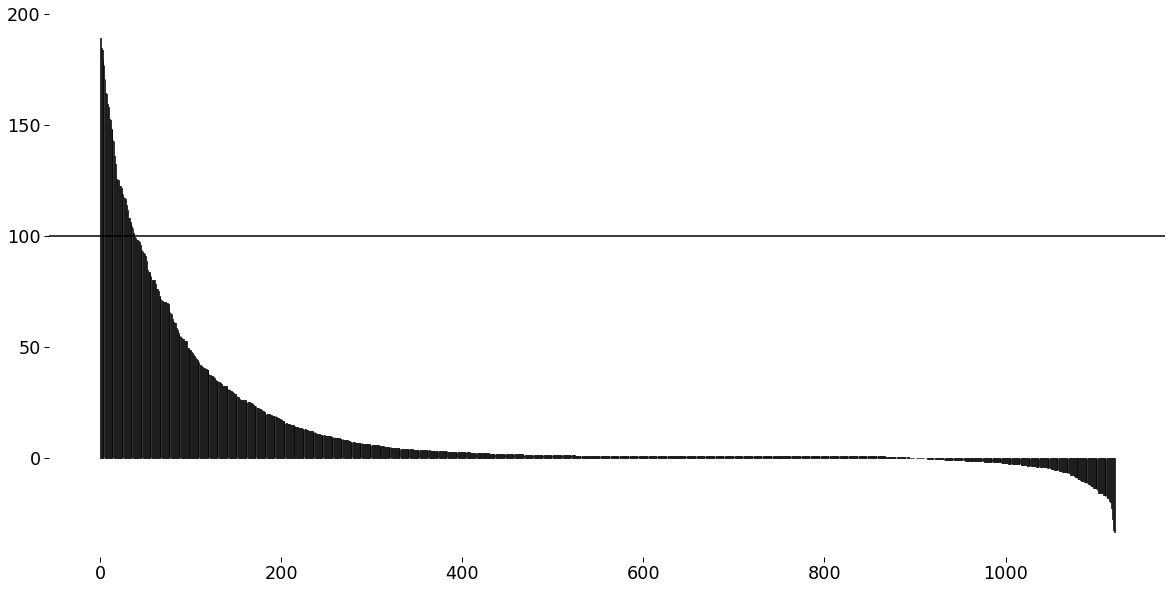

In [211]:
x = list(df_with_genotypes.index)
y = list(df_with_genotypes['Predicted_strict_production'])

bar_plot(x, y, path = 'ConStrain_on_google_colab/data/10-plots/07_1_LEARN_DataAnalysis/barplot_predicting_remaining_best_combinations_2701',
        size_height =  10, 
         size_length = 20)

In [212]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,189.410583
1,Smus,ENO2,TPI1,Cac,184.930663
2,Smus,ENO2,TPI1,Aan,183.786563
3,Rsep,ENO2,TPI1,Ara,179.451003
4,Smus,ENO2,CCW12,Ara,177.130989
...,...,...,...,...,...
1116,Opum,CYC1,TPI1,Ani,-19.791379
1117,Cacu,CYC1,TPI1,Clo,-22.477388
1118,Oeu,CYC1,TPI1,Ahu,-27.497594
1119,Oeu,CYC1,TPI1,Ani,-32.604113


Lets save the dataframes into csv files

In [213]:
## getting a unique name
#from datetime import datetime
#now = datetime.now() # current date and time
#time = now.strftime("%Y_%m_%d_%H:%M_")
#
#name = 'top_ML_predicted_after_first_DBTL_merged_analytics'
#path = 'ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/'
#
#df_with_genotypes.to_csv(path+time+name+'.csv', index=False)

## 7. Top 20 predicted producers of the unseen library

Lets look at the file generated first from one of the first models. 

In [214]:
df_with_genotypes = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/all_predictions/first_round/top_ML_predicted_after_first_DBTL_merged_analytics.csv')

In [215]:
df_with_genotypes

,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Cro,189.410583
1,Smus,ENO2,TPI1,Cac,184.930663
2,Smus,ENO2,TPI1,Aan,183.786563
3,Rsep,ENO2,TPI1,Ara,179.451003
4,Smus,ENO2,CCW12,Ara,177.130989
...,...,...,...,...,...
1116,Opum,CYC1,TPI1,Ani,-19.791379
1117,Cacu,CYC1,TPI1,Clo,-22.477388
1118,Oeu,CYC1,TPI1,Ahu,-27.497594
1119,Oeu,CYC1,TPI1,Ani,-32.604113


Adding unique names 

In [147]:
df_with_genotypes['names'] = df_with_genotypes['G8H']+'-' +df_with_genotypes['pG8H']+ '_'+ df_with_genotypes['pCPR']+'_'+df_with_genotypes['CPR']

In [148]:
from constrain.plotting.plotting import horisontal_bar_plot

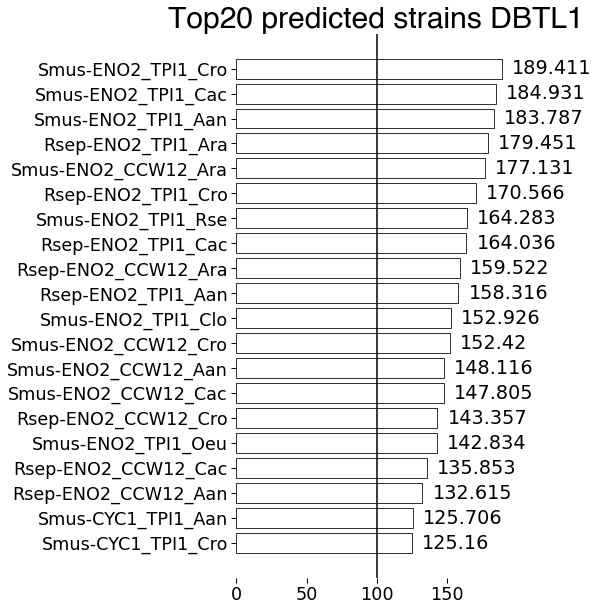

In [149]:
# Plotting top 20 strains
x_axis = list(df_with_genotypes['names'])[:20][::-1]
y_axis = list(df_with_genotypes['Predicted_strict_production'])[:20][::-1]

horisontal_bar_plot(x_axis,y_axis, path = 'ConStrain_on_google_colab/data/10-plots/07_1_LEARN_DataAnalysis/Top20 predicted strains DBTL1', 
                    title = 'Top20 predicted strains DBTL1', 
                   size_height=5, 
                   size_length=10)

### 7.1 How many genotypes are predicted to produce more than the control strain?

In [151]:
over_100_strict_procduction = df_with_genotypes[df_with_genotypes['Predicted_strict_production'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(df_with_genotypes)} are predicted to produce strictosidine over the normalized value")
print(f"Out of the remaing theoretical space these constittue : {(len(over_100_strict_procduction)/len(df_with_genotypes))*100}")

38 strains out of 1121 are predicted to produce strictosidine over the normalized value
Out of the remaing theoretical space these constittue : 3.389830508474576


## 8. Learning curve on partitioned data

In [152]:
from constrain.machine_learning.auto_ml import autoML_on_partitioned_data

In [153]:
shuffled_new_input_for_ml = new_input_for_ml.sample(frac=1, random_state= 2).reset_index(drop=True) # Random state sets a seed on the shuffeling
shuffled_new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
0,yp49_E10,2,2,6,10,6
1,yp49_C11,2,2,5,2,34
2,yp50_B11,4,1,8,8,5
3,yp49_F12,3,1,8,4,4
4,yp50_E07,5,1,6,9,75
...,...,...,...,...,...,...
162,yp51_C05,7,1,8,10,0
163,yp51_B11,7,3,8,8,6
164,yp50_C08,5,4,6,1,34
165,yp50_G02,6,3,8,5,0


Already did this. It takes +20 hours on my laptop.

In [154]:
#feature_cols = ['0', '1', '2', '3']
#training_column = 'Amt_norm'
#
## Training 3 partitions 5 times - the function is set to nfold = 10  by default. 
#for i in range(0,3): 
#    autoML_on_partitioned_data(feature_cols, training_column,
#                               new_input_for_ml,
#                               training_time=0, 
#                               partitions = 3,
#                               nfold= 10,
#                               path = 'ConStrain_on_google_colab/data/09-AutoML/learning_curve_data/first_round/0sec_experiment/NOT_shuffled_60sec/')

### 8.1 - visualizing learning curve

In [155]:
import os

# folder path
dir_path = 'ConStrain_on_google_colab/data/09-AutoML/learning_curve_data/first_round/nfold_10/0sec_experiment/shuffled_random2/'

# list file and directories
res = os.listdir(dir_path)
res

['2023_01_06_05:49_ml_models_running_over_partioned_data.csv',
 '2023_01_13_18:55_ml_models_running_over_partioned_data.csv',
 '.DS_Store',
 '2023_01_13_02:09_ml_models_running_over_partioned_data.csv',
 '2023_01_06_08:46_ml_models_running_over_partioned_data.csv',
 '2023_01_06_02:51_ml_models_running_over_partioned_data.csv',
 '2023_01_12_23:05_ml_models_running_over_partioned_data.csv',
 '2023_01_13_21:53_ml_models_running_over_partioned_data.csv',
 '2023_01_14_00:49_ml_models_running_over_partioned_data.csv']

In [156]:
lst_of_pd_dataframes = []
for ml_partitioned in res:
    if ml_partitioned.endswith('.csv'):
        lst_of_pd_dataframes.append(pd.read_csv(dir_path+ml_partitioned))

Lets retrieve the data 

In [157]:
dfs = [df.set_index('Unnamed: 0') for df in lst_of_pd_dataframes]
concated = pd.concat(dfs, axis=1)
concated

,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,...,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name,0,CV_mean_MAE,CV_SD_MAE,Model_name
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
56,7.025441,19.155186,11.301745,StackedEnsemble_BestOfFamily_7_AutoML_121_2023...,5.056537,14.440454,8.924766,GBM_lr_annealing_selection_AutoML_1_20230113_1...,13.591087,15.611847,...,11.016384,XGBoost_grid_1_AutoML_80_20230112_200151_model_20,5.056537,14.440454,8.924766,GBM_lr_annealing_selection_AutoML_4_20230113_1...,5.056537,14.440454,8.924766,GBM_lr_annealing_selection_AutoML_7_20230113_2...
112,5.893442,12.388891,6.663127,XGBoost_lr_search_selection_AutoML_122_2023010...,6.409456,10.932010,5.968863,XGBoost_grid_1_AutoML_2_20230113_165812_model_213,5.799110,11.606876,...,5.953909,GBM_grid_1_AutoML_82_20230112_210404_model_12,6.864274,8.888928,4.541182,StackedEnsemble_BestOfFamily_6_AutoML_5_202301...,8.036937,9.652630,4.434284,StackedEnsemble_BestOfFamily_6_AutoML_8_202301...
167,4.122551,8.895870,5.215116,XGBoost_lr_search_selection_AutoML_123_2023010...,5.698090,9.558352,6.966326,XGBoost_lr_search_selection_AutoML_3_20230113_...,5.177059,12.085532,...,6.335171,GBM_grid_1_AutoML_83_20230112_220508_model_12,5.698090,9.558352,6.966326,XGBoost_lr_search_selection_AutoML_6_20230113_...,5.698090,9.558352,6.966326,XGBoost_lr_search_selection_AutoML_9_20230113_...


In [158]:
# test results
test_results = concated[['0']]
test_results['mean'] = test_results.mean(axis=1)
test_results['std'] = test_results.std(axis=1)
test_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1020/934127194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['mean'] = test_results.mean(axis=1)
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1020/934127194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_results['std'] = test_results.std(axis=1)


,0,0,0,0,0,0,0,0,mean,std
Unnamed: 0,,,,,,,,,,
56,7.025441,5.056537,13.591087,7.656707,7.656707,13.591087,5.056537,5.056537,8.086330,3.347355
112,5.893442,6.409456,5.799110,6.699459,6.699459,5.799110,6.864274,8.036937,6.525156,0.700712
167,4.122551,5.698090,5.177059,3.638762,4.122551,5.177059,5.698090,5.698090,4.916531,0.779563


In [159]:
# Cross-validated mean MAE
cross_validated_results = concated[['CV_mean_MAE']]
cross_validated_results['mean'] = cross_validated_results.mean(axis=1)
cross_validated_results

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1020/994047639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results['mean'] = cross_validated_results.mean(axis=1)


,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,CV_mean_MAE,mean
Unnamed: 0,,,,,,,,,
56,19.155186,14.440454,15.611847,20.952682,20.952682,15.611847,14.440454,14.440454,16.950701
112,12.388891,10.932010,11.606876,12.135951,12.135951,11.606876,8.888928,9.652630,11.168514
167,8.895870,9.558352,12.085532,9.155954,8.895870,12.085532,9.558352,9.558352,9.974227


In [160]:
# Cross-validated mean SD
cross_validated_results_sd = concated[['CV_SD_MAE']]
cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)
cross_validated_results_sd

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_1020/3504483626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_validated_results_sd['mean'] = cross_validated_results_sd.mean(axis=1)


,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,CV_SD_MAE,mean
Unnamed: 0,,,,,,,,,
56,11.301745,8.924766,11.016384,13.668060,13.668060,11.016384,8.924766,8.924766,10.930616
112,6.663127,5.968863,5.953909,6.503198,6.503198,5.953909,4.541182,4.434284,5.815209
167,5.215116,6.966326,6.335171,5.512427,5.215116,6.335171,6.966326,6.966326,6.188997


In [161]:
from constrain.plotting.plotting import plot_ml_learning_curve

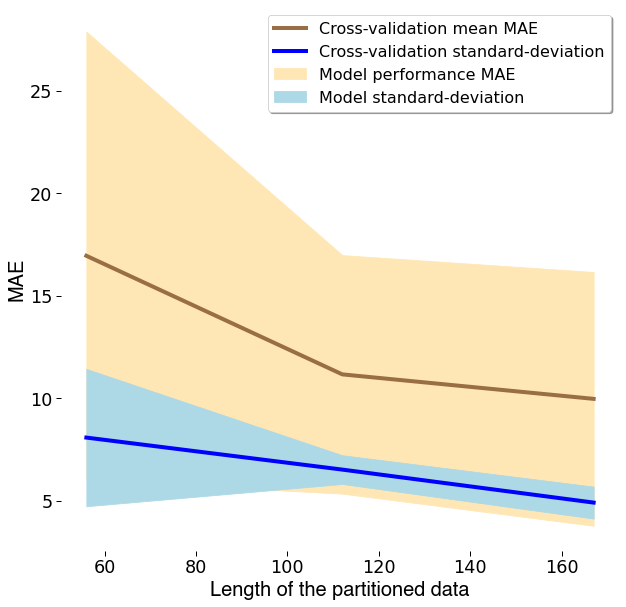

In [162]:
# CV
x = list(cross_validated_results.index)
y = list(cross_validated_results['mean'])
sd =  list(cross_validated_results_sd['mean'])

# model_performance
y1 = list(test_results['mean'])
sd1 = np.array(list(test_results['std']))


plot_ml_learning_curve(x, y1, y,sd1,  sd, save_pdf = True ,
                       path = 'ConStrain_on_google_colab/data/10-plots/07_1_LEARN_DataAnalysis/Learning_curve_on_partitioned_data_DBTL1_12_01_2023_10_height_10_length', 
                             size_height = 10,
                             size_length = 10, 
                             linewidth=4)